# Submission Information:

### Team Member 1:
* UNI:  WL2522
* Name:  Wilson Lui

### Team Member 2 [optional]:
* UNI:  
* Name:

# Step0 - Import Libraries, Load Data [0 points]

This is the basic step where you can load the data and create train and test sets for internal validation as per your convinience.

In [197]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder, scale, OneHotEncoder, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, SGDClassifier
from sklearn.feature_selection import RFE, SelectKBest, mutual_info_classif, f_classif
from sklearn.svm import LinearSVC 
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier

from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE

data = pd.read_csv('data\data.csv')


In [198]:
#Separate the ID column from the holdout set


holdout = pd.read_csv('data\holdout.csv')
ID = holdout['ID']
holdout = holdout.drop('ID', 1)


#Remove the "duration" feature to avoid getting overoptimistic results


data = data.drop('duration', 1)
holdout = holdout.drop('duration', 1)


In [290]:
#Convert the "month" and "day_of_week" features to integers


months = [('mar', 3), ('apr', 4), ('may', 5), ('jun', 6), ('jul', 7), ('aug', 8),
          ('sep', 9), ('oct', 10), ('nov', 11), ('dec', 12)]
weekdays = [('mon', 1), ('tue', 2), ('wed', 3), ('thu', 4), ('fri', 5)]

for month in months:
    data['month'].replace(to_replace=month[0], value=month[1], inplace=True)
    holdout['month'].replace(to_replace=month[0], value=month[1], inplace=True)
    
for day in weekdays:
    data['day_of_week'].replace(to_replace=day[0], value=day[1], inplace=True)
    


0        1
1        3
2        5
3        3
4        4
5        1
6        1
7        3
8        1
9        5
10       5
11       2
12       5
13       4
14       4
15       1
16       1
17       2
18       2
19       2
20       5
21       5
22       1
23       3
24       1
25       5
26       1
27       4
28       1
29       2
        ..
32920    4
32921    5
32922    2
32923    2
32924    1
32925    2
32926    4
32927    3
32928    2
32929    3
32930    2
32931    2
32932    3
32933    1
32934    2
32935    5
32936    3
32937    5
32938    2
32939    1
32940    3
32941    4
32942    5
32943    2
32944    5
32945    2
32946    3
32947    2
32948    1
32949    3
Name: day_of_week, dtype: int64


In [292]:
#Create a copy of the dataset for encoding purposes and leave the original for visualizations
#Separate the categorical features from the numerical ones
#Encode category and response variable strings to integers
#Treat "prev_days" as a categorical variable due to the large majority of 999 values


num = ['age', 'month', 'day_of_week', 'campaign', 'prev_contacts','emp_var_rate',
       'cons_price_idx', 'cons_conf_idx', 'euribor3m', 'nr_employed']

cat = ['job', 'marital_status', 'education', 'credit_default', 'housing',
       'loan', 'contact', 'prev_days', 'prev_outcomes']


enc_data = data.copy()
enc_holdout = holdout.copy()

le = LabelEncoder()


for col in cat:
    levels = np.concatenate((enc_data[col].unique(), enc_holdout[col].unique()))
    le.fit(levels)
    enc_data[col] = le.transform(enc_data[col])
    enc_holdout[col] = le.transform(enc_holdout[col])


In [293]:
#Encode the response variable
#Separate the features from the response variable


levels = enc_data['subscribed'].unique()
le.fit(levels)
enc_data['subscribed'] = le.transform(enc_data['subscribed'])

X = enc_data.iloc[:,:-1]
y = enc_data.iloc[:,-1]


In [294]:
#Balance the dataset using Random Undersampling, SMOTE, and SMOTE + Edited Nearest Neighbors
#Create a different train/test split for each balanced datasert


rus = RandomUnderSampler(replacement=True)
sm = SMOTE()
enn = SMOTEENN()

X_rus, y_rus = rus.fit_sample(X, y)
X_sm, y_sm = sm.fit_sample(X, y)
X_enn, y_enn = enn.fit_sample(X, y)

X_train_rus, X_test_rus, y_train_rus, y_test_rus = train_test_split(X_rus, y_rus, stratify=y_rus)
X_train_sm, X_test_sm, y_train_sm, y_test_sm = train_test_split(X_sm, y_sm, stratify=y_sm)
X_train_enn, X_test_enn, y_train_enn, y_test_enn = train_test_split(X_enn, y_enn, stratify=y_enn)


# Step1 - Exploration and Preparation [10 points]

In this step, we expect you to look into the data and try to understand it before modeling. This understanding may lead to some basic data preparation steps which are common across the two model sets required.

In [62]:
#Get summary statistics on the data


data.describe()

,age,campaign,prev_days,prev_contacts,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed
count,32950.000000,32950.000000,32950.000000,32950.000000,32950.000000,32950.000000,32950.000000,32950.000000,32950.000000
mean,40.019059,2.641639,961.537906,0.174385,0.080115,93.583705,-40.496740,3.618901,5166.932832
std,10.850807,2.803230,189.209917,0.498989,1.573180,1.162662,4.645301,1.737149,72.439480
min,17.000000,1.000000,0.000000,0.000000,-3.695294,88.311974,-52.220779,0.325461,4963.600000
25%,32.000000,1.000000,999.000000,0.000000,-1.724208,92.800661,-43.087110,1.377065,5101.000000
50%,38.000000,2.000000,999.000000,0.000000,1.085053,93.586959,-41.685507,4.800570,5194.000000
75%,47.000000,3.000000,999.000000,0.000000,1.366367,94.381404,-36.404580,4.943674,5226.000000
max,97.000000,56.000000,999.000000,7.000000,1.785673,98.263042,-25.323735,5.362403,5249.000000


Counter({'admin.': 8342, 'blue-collar': 7408, 'technician': 5371, 'services': 3168, 'management': 2340, 'retired': 1390, 'entrepreneur': 1198, 'self-employed': 1140, 'housemaid': 827, 'unemployed': 797, 'student': 708, 'unknown': 261})


([<matplotlib.axis.XTick at 0x265691f5400>,
 <a list of 12 Text xticklabel objects>)

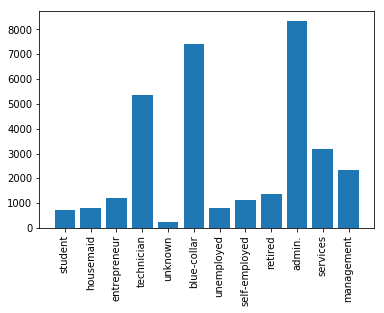

In [3]:
#Examine the distribution of job categories


job_count = Counter(data['job'])
print(job_count)
plt.bar(range(len(job_count)), job_count.values(), align='center')
plt.xticks(range(len(job_count)), list(job_count.keys()), rotation='vertical')


Counter({'married': 19955, 'single': 9256, 'divorced': 3676, 'unknown': 63})


([<matplotlib.axis.XTick at 0x26569153080>,
 <a list of 4 Text xticklabel objects>)

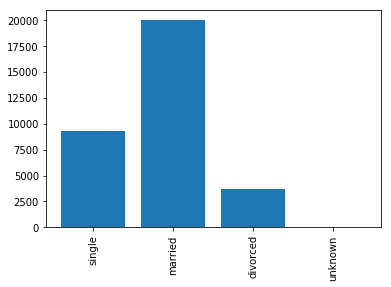

In [4]:
#Examine the distribution of marital statuses


marital_count = Counter(data['marital_status'])
print(marital_count)
plt.bar(range(len(marital_count)), marital_count.values(), align='center')
plt.xticks(range(len(marital_count)), list(marital_count.keys()), rotation='vertical')


Counter({'university.degree': 9760, 'high.school': 7580, 'basic.9y': 4889, 'professional.course': 4154, 'basic.4y': 3313, 'basic.6y': 1846, 'unknown': 1394, 'illiterate': 14})


([<matplotlib.axis.XTick at 0x2656919ba58>,
 <a list of 8 Text xticklabel objects>)

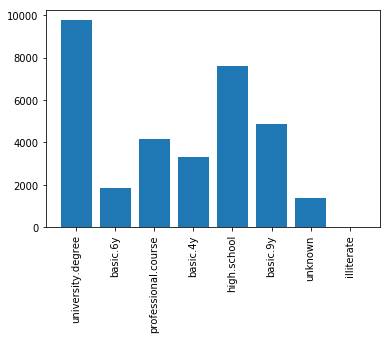

In [5]:
#Examine the distribution of education levels


education_count = Counter(data['education'])
print(education_count)
plt.bar(range(len(education_count)), education_count.values(), align='center')
plt.xticks(range(len(education_count)), list(education_count.keys()), rotation='vertical')


Counter({'may': 11016, 'jul': 5716, 'aug': 4954, 'jun': 4272, 'nov': 3299, 'apr': 2097, 'oct': 540, 'sep': 465, 'mar': 437, 'dec': 154})


([<matplotlib.axis.XTick at 0x1b436d3cd68>,
 <a list of 10 Text xticklabel objects>)

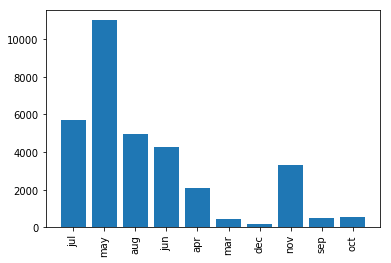

In [56]:
#Examine the distribution of call months


month_count = Counter(data['month'])
print(month_count)
plt.bar(range(len(month_count)), month_count.values(), align='center')
plt.xticks(range(len(month_count)), list(month_count.keys()), rotation='vertical')


Counter({'thu': 6945, 'mon': 6749, 'wed': 6531, 'tue': 6495, 'fri': 6230})


([<matplotlib.axis.XTick at 0x1b436e87c50>,
 <a list of 5 Text xticklabel objects>)

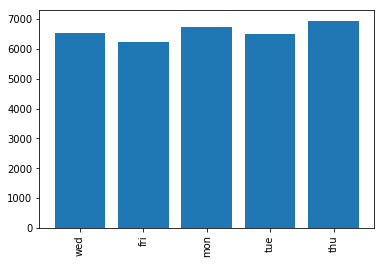

In [58]:
#Examine the distribution of days of the week


week_count = Counter(data['day_of_week'])
print(week_count)
plt.bar(range(len(week_count)), week_count.values(), align='center')
plt.xticks(range(len(week_count)), list(week_count.keys()), rotation='vertical')


Counter({999: 31707, 3: 373, 6: 332, 4: 105, 9: 55, 7: 48, 2: 46, 12: 45, 5: 42, 10: 40, 13: 26, 11: 23, 1: 19, 15: 18, 14: 17, 8: 13, 0: 11, 16: 10, 17: 5, 18: 4, 19: 3, 22: 3, 21: 2, 20: 1, 26: 1, 27: 1})


([<matplotlib.axis.XTick at 0x1b4386670b8>,
 <a list of 26 Text xticklabel objects>)

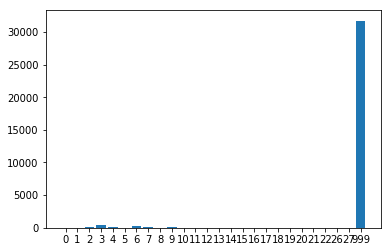

In [174]:
#Examine the distribution of previous days since last contact


days_count = Counter(data['prev_days'])
print(days_count)
plt.bar(range(len(days_count)), days_count.values(), align='center')
plt.xticks(range(len(days_count)), list(days_count.keys()))


Counter({'no': 26059, 'unknown': 6888, 'yes': 3})
Counter({'yes': 17176, 'no': 14974, 'unknown': 800})
Counter({'no': 27179, 'yes': 4971, 'unknown': 800})
Counter({'cellular': 20902, 'telephone': 12048})


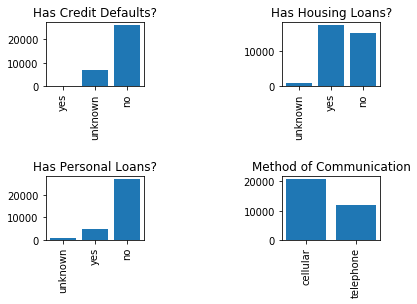

In [6]:
#Examine distribution of binary variables


default_count = Counter(data['credit_default'])
housing_count = Counter(data['housing'])
loan_count = Counter(data['loan'])
contact_count = Counter(data['contact'])
print(default_count)
print(housing_count)
print(loan_count)
print(contact_count)

ax1 = plt.subplot('331')
plt.bar(range(len(default_count)), default_count.values(), align='center')
plt.xticks(range(len(default_count)), list(default_count.keys()), rotation='vertical')
ax1.set_title('Has Credit Defaults?')

ax2 = plt.subplot('333')
plt.bar(range(len(housing_count)), housing_count.values(), align='center')
plt.xticks(range(len(housing_count)), list(housing_count.keys()), rotation='vertical')
ax2.set_title('Has Housing Loans?')

ax3 = plt.subplot('337')
plt.bar(range(len(loan_count)), loan_count.values(), align='center')
plt.xticks(range(len(loan_count)), list(loan_count.keys()), rotation='vertical')
ax3.set_title('Has Personal Loans?')

ax4 = plt.subplot('339')
plt.bar(range(len(contact_count)), contact_count.values(), align='center')
plt.xticks(range(len(contact_count)), list(contact_count), rotation='vertical')
ax4.set_title('Method of Communication')


nr_employed/euribor3m correlation 
 [[ 1.         0.9418152]
 [ 0.9418152  1.       ]]
nr_employed/emp_var_rate correlation 
 [[ 1.          0.90294658]
 [ 0.90294658  1.        ]]


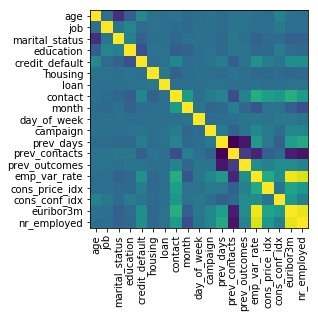

In [102]:
#Create covariance matrix heatmap to check for correlated features


cov = np.cov(scale(X_train), rowvar = False)
plt.imshow(cov, cmap='viridis', interpolation='nearest')
plt.xticks(range(len(list(X_train))), list(X_train), rotation = 'vertical')
plt.yticks(range(len(list(X_train))), list(X_train))

print('nr_employed/euribor3m correlation \n', np.corrcoef(data['nr_employed'], data['euribor3m']))
print('nr_employed/emp_var_rate correlation \n', np.corrcoef(data['nr_employed'], data['emp_var_rate']))

# Step2 - ModelSet1 [35 points]

In this step, we expect you to perform the following steps relevant to the models you choose for set1:

* feature engineering
* validation
* feature selection
* final model selection

You may select up to 5 models in this step for the purpose of final ensemble. Any classification algorithm covered in class apart from tree-based models can be tested here.

In [295]:
#Perform One Hot Encoding on each training sets


discrete = [1, 2, 3, 4, 5, 6, 7, 11, 13]

def OHE(X, discrete_features):
    """Performs one hot encoding on the input array using scikit-learn's 
    OneHotEncoder()
    
    Parameters
    ----------
    X : NumPy array
    discrete_features : list
    
    Returns
    -------
    NumPy array
        array with the categorical features replaced with encoded features
    
    """

    OHE = OneHotEncoder().fit(X[:, [discrete_features]].reshape(-1,1))
    enc_discrete = OHE.transform(X[:,1].reshape(-1,1)).toarray()

    for col in discrete_features[1:]:
        enc = OneHotEncoder().fit_transform(X[:, col].reshape(-1,1)).toarray()
        enc_discrete = np.append(enc_discrete, enc, axis = 1)

    X = np.delete(X, discrete_features, axis=1)
    X = np.append(X, enc_discrete, axis = 1)
    
    return X


In [296]:
#Determine feature importance with RFE using SVMs


svc = LinearSVC()
svc_rfe = RFE(svc, n_features_to_select = 10)

sm = svc_rfe.fit(X_train_sm, y_train_sm)
print('sm', sm.ranking_)

rus = svc_rfe.fit(X_train_rus, y_train_rus)
print('rus', rus.ranking_)

enn = svc_rfe.fit(X_train_enn, y_train_enn)
print('enn', enn.ranking_)


sm [ 9 10  1  4  1  5  1  1  6  3  1  7  1  1  1  2  1  1  8]
rus [ 1  8  1  1  1 10  3  1  1  2  1  7  1  1  6  4  5  1  9]
enn [10  7  1  2  1  6  1  1  3  4  1  8  1  1  5  1  1  1  9]


In [297]:
#Determine feature importance with RFE using Logistic Regression


lr = LogisticRegression(n_jobs=8)
lr_rfe = RFE(lr, n_features_to_select = 10)

sm_lr = lr_rfe.fit(X_train_sm, y_train_sm)
rus_lr = lr_rfe.fit(X_train_rus, y_train_rus)
enn_lr = lr_rfe.fit(X_train_enn, y_train_enn)

print('sm', sm_lr.ranking_)
print('rus', rus_lr.ranking_)
print('enn', enn_lr.ranking_)


sm [ 8  7  1  3  1  5  1  1 10  4  1  6  1  1  1  1  2  1  9]
rus [ 8  7  1  3  1  5  1  1 10  4  1  6  1  1  1  1  2  1  9]
enn [ 8  7  1  3  1  5  1  1 10  4  1  6  1  1  1  1  2  1  9]


In [298]:
#Determine feature importance with F-scores, mutual information, and SelectKBest


f = SelectKBest(f_classif, k=10)
mi = SelectKBest(mutual_info_classif, k=10)
                
f.fit(X_train_sm, y_train_sm)
mi.fit(X_train_sm, y_train_sm)

print('f', f.get_support())
print('mi', mi.get_support())


f [False False False False  True False False  True False False  True  True
  True  True  True  True False  True  True]
mi [ True  True  True  True False  True False False  True  True  True False
 False False False False False  True  True]


In [300]:
#Determine feature importance with stability selection using Logistic Regression


from sklearn.linear_model import RandomizedLogisticRegression

rlr = RandomizedLogisticRegression()

rus_rlr = rlr.fit(X_train_rus, y_train_rus)
sm_rlr = rlr.fit(X_train_sm, y_train_sm)
enn_rlr = rlr.fit(X_train_enn, y_train_enn)

print('sm', sm_rlr.scores_)
print('rus', rus_rlr.scores_)
print('enn', enn_rlr.scores_)


sm [ 0.     0.06   0.7    0.785  1.     0.02   0.5    1.     0.275  0.37   1.
  0.89   0.16   1.     0.62   0.075  0.98   0.125  1.   ]
rus [ 0.     0.06   0.7    0.785  1.     0.02   0.5    1.     0.275  0.37   1.
  0.89   0.16   1.     0.62   0.075  0.98   0.125  1.   ]
enn [ 0.     0.06   0.7    0.785  1.     0.02   0.5    1.     0.275  0.37   1.
  0.89   0.16   1.     0.62   0.075  0.98   0.125  1.   ]


In [301]:
#Drop the features deemed to be unimportant: "age", "housing", "nr_employed"
#Determine the best resampling technique to use with Logistic Regression


dropped = [0, 5, 18]
leftover_discrete = [0, 1, 2, 3, 4, 5, 6, 7, 9, 11]

X_train_rus_enc = OHE(np.delete(X_train_rus, dropped, axis=1), leftover_discrete)
X_train_sm_enc = OHE(np.delete(X_train_sm, dropped, axis=1), leftover_discrete)
X_train_enn_enc = OHE(np.delete(X_train_enn, dropped, axis=1), leftover_discrete)

pipe = make_pipeline(StandardScaler(), LogisticRegressionCV(n_jobs=8))

rus_score = cross_val_score(pipe, X_train_rus_enc, y_train_rus, cv=10, scoring='roc_auc')
print('rus', np.mean(rus_score))

sm_score = cross_val_score(pipe, X_train_sm_enc, y_train_sm, cv=10, scoring='roc_auc')
print('sm', np.mean(sm_score))

enn_score = cross_val_score(pipe, X_train_enn_enc, y_train_enn, cv=10, scoring='roc_auc')
print('enn', np.mean(enn_score))
    

rus 0.782992145359
sm 0.876977292477
enn 0.880473828847


In [305]:
#Drop the features deemed to be unimportant: "age", "job", "housing", "nr_employed"
#Determine the best resampling technique to use with Logistic Regression


dropped = [0, 1, 5, 18]
leftover_discrete = [0, 1, 2, 3, 4, 5, 6, 8, 10]

X_train_rus_enc = OHE(np.delete(X_train_rus, dropped, axis=1), leftover_discrete)
X_train_sm_enc = OHE(np.delete(X_train_sm, dropped, axis=1), leftover_discrete)
X_train_enn_enc = OHE(np.delete(X_train_enn, dropped, axis=1), leftover_discrete)

pipe = make_pipeline(StandardScaler(), LogisticRegressionCV(n_jobs=8))

rus_score = cross_val_score(pipe, X_train_rus_enc, y_train_rus, cv=10, scoring='roc_auc')
print('rus', np.mean(enn_score))

sm_score = cross_val_score(pipe, X_train_sm_enc, y_train_sm, cv=10, scoring='roc_auc')
print('sm', np.mean(enn_score))

enn_score = cross_val_score(pipe, X_train_enn_enc, y_train_enn, cv=10, scoring='roc_auc')
print('enn', np.mean(enn_score))
    

rus 0.877305717486
sm 0.877305717486
enn 0.877324450539


In [308]:
X_test_rus_enc = OHE(np.delete(X_test_rus, dropped, axis=1), leftover_discrete)
X_test_sm_enc = OHE(np.delete(X_test_sm, dropped, axis=1), leftover_discrete)
X_test_enn_enc = OHE(np.delete(X_test_enn, dropped, axis=1), leftover_discrete)

rus_pipe = pipe.fit(X_train_rus_enc, y_train_rus)
print(pipe.score(X_test_rus_enc, y_test_rus))

sm_pipe = pipe.fit(X_train_sm_enc, y_train_sm)
print(pipe.score(X_test_sm_enc, y_test_sm))

enn_pipe = pipe.fit(X_train_enn_enc, y_train_enn)
print(pipe.score(X_test_enn_enc, y_test_enn))

ValueError: operands could not be broadcast together with shapes (1856,83) (85,) (1856,83) 

In [303]:
#Drop the features deemed to be unimportant: "age", "job", "housing", cons_price_idx, "nr_employed"
#Determine the best resampling technique to use with Logistic Regression


dropped = [0, 1, 5, 15, 18]
leftover_discrete = [0, 1, 2, 3, 4, 5, 6, 8, 10]

X_train_rus_enc = OHE(np.delete(X_train_rus, dropped, axis=1), leftover_discrete)
X_train_sm_enc = OHE(np.delete(X_train_sm, dropped, axis=1), leftover_discrete)
X_train_enn_enc = OHE(np.delete(X_train_enn, dropped, axis=1), leftover_discrete)

pipe = make_pipeline(StandardScaler(), LogisticRegressionCV(n_jobs=8))

rus_score = cross_val_score(pipe, X_train_rus_enc, y_train_rus, cv=10, scoring='roc_auc')
print('rus', np.mean(enn_score))

sm_score = cross_val_score(pipe, X_train_sm_enc, y_train_sm, cv=10, scoring='roc_auc')
print('sm', np.mean(enn_score))

enn_score = cross_val_score(pipe, X_train_enn_enc, y_train_enn, cv=10, scoring='roc_auc')
print('enn', np.mean(enn_score))

rus 0.877324450539
sm 0.877324450539
enn 0.877305717486


In [304]:
#Determine the best resampling technique to use with SGDClassifier

dropped = [0, 1, 5, 18]
leftover_discrete = [0, 1, 2, 3, 4, 5, 6, 8, 10]

X_train_rus_enc = OHE(np.delete(X_train_rus, dropped, axis=1), leftover_discrete)
X_train_sm_enc = OHE(np.delete(X_train_sm, dropped, axis=1), leftover_discrete)
X_train_enn_enc = OHE(np.delete(X_train_enn, dropped, axis=1), leftover_discrete)

grid = {'alpha': np.logspace(-1,7, 9)}

methods = [(X_train_rus, y_train_rus), (X_train_sm, y_train_sm), (X_train_enn, y_train_enn)]
scaler = StandardScaler()
for array in methods:
    gridsearch = GridSearchCV(SGDClassifier(loss='modified_huber', n_iter=np.ceil(10**6/np.shape(array[0])[0])),
                                     param_grid=grid, scoring='roc_auc', cv=15)
    
    sgd = gridsearch.fit(scaler.fit_transform(array[0]), array[1])
    print('best score', sgd.score(array[0], array[1]))
    print('best parameters', sgd.best_params_)
    
rus_grid = GridSearchCV(SGDClassifier(loss='modified_huber', n_iter=np.ceil(10**6/np.shape(X_train_rus_enc)[0])),param_grid=grid, scoring='roc_auc', cv=15)
sm_grid = GridSearchCV(SGDClassifier(loss='modified_huber', n_iter=np.ceil(10**6/np.shape(X_train_sm_enc)[0])),param_grid=grid, scoring='roc_auc', cv=15)
enn_grid = GridSearchCV(SGDClassifier(loss='modified_huber', n_iter=np.ceil(10**6/np.shape(X_train_enn_enc)[0])),param_grid=grid, scoring='roc_auc', cv=15)

rus_sgd = sgd_grid.fit(scaler.fit_transform(X_train_rus_enc), y_train_rus)

print('rus best score', rus_sgd.score(X_train_rus_enc, y_train_rus))
print('rus best parameters', rus_sgd.best_params_)

sm_sgd = sgd_grid.fit(scaler.fit_transform(X_train_sm_enc), y_train_sm)

print('sm best score', sm_sgd.score(X_train_sm_enc, y_train_sm))
print('sm best parameters', sm_sgd.best_params_)

enn_sgd = sgd_grid.fit(scaler.fit_transform(X_train_enn_enc), y_train_enn)

print('enn best score', enn_sgd.score(X_train_enn_enc, y_train_enn))
print('enn best parameters', enn_sgd.best_params_)


best score 0.750422286836
best parameters {'alpha': 1.0}
best score 0.753662856658
best parameters {'alpha': 0.10000000000000001}
best score 0.760844223899
best parameters {'alpha': 0.10000000000000001}
rus best score 0.758962983262
rus best parameters {'alpha': 1.0}
sm best score 0.683213810036
sm best parameters {'alpha': 0.10000000000000001}
enn best score 0.688385852212
enn best parameters {'alpha': 0.10000000000000001}


In [157]:

gd_pipe = make_pipeline(StandardScaler(),
                         SGDClassifier(alpha=10,loss='modified_huber',n_iter=np.ceil(10**6/np.shape(X_train_enn_enc)[0])))

sgd_score = cross_val_score(sgd_pipe, X_test, y_train_enn, cv=5, scoring='roc_auc')


[ 0.82955597  0.83429874  0.83208014  0.84074337  0.83063209]


# Step3 - ModelSet2 [35 points]

In this step, we expect you to perform the following steps relevant to the models you choose for set2:

* feature engineering
* validation
* feature selection
* final model selection

You may select up to 5 models in this step for the purpose of final ensemble. We encourage you to try decition tree, random forest and gradient boosted tree methods here and pick the one which you think works best.

In [193]:
#Perform a grid search to find the optimal Decision Tree parameter values for max_depth and max_features


grid = {'max_features': range(3, 15, 1), 'max_depth': np.linspace(5, 50, 2)}

search = GridSearchCV(DecisionTreeClassifier(), param_grid = grid, scoring='roc_auc', cv=10)

rus = search.fit(X_train_rus, y_train_rus)
sm = search.fit(X_train_sm, y_train_sm)
enn = search.fit(X_train_enn, y_train_enn)

print(rus.score(X_train_rus, y_train_rus))
print(rus.best_params_)
print(sm.score(X_train_sm, y_train_sm))
print(sm.best_params_)
print(enn.score(X_train_enn, y_train_enn))
print(enn.best_params_)


0.901939655172
{'max_depth': 50.0, 'max_features': 10}
0.962902424941
{'max_depth': 50.0, 'max_features': 10}
1.0
{'max_depth': 50.0, 'max_features': 10}


In [195]:
#Perform cross-validation using the entire dataset and the optimal parameters
#Determine the best resampling technique


dt = DecisionTreeClassifier(max_features=10, max_depth=50)

print(cross_val_score(dt, X_rus, y_rus, cv=10, scoring='roc_auc'))
print(cross_val_score(dt, X_sm, y_sm, cv=10, scoring='roc_auc'))
print(cross_val_score(dt, X_enn, y_enn, cv=10, scoring='roc_auc'))

[ 0.6922043   0.65456989  0.70754717  0.6819407   0.64959569  0.64555256
  0.65229111  0.67789757  0.65633423  0.68463612]
[ 0.64637483  0.86114911  0.93194254  0.92989056  0.93125855  0.93023256
  0.93177155  0.93040356  0.93345878  0.92593226]
[ 0.65208293  0.85575044  0.92689401  0.93133591  0.9315354   0.93630301
  0.93457674  0.93216625  0.93288443  0.93805281]


# Step4 - Ensemble [20 points + 10 Bonus points]

In this step, we expect you to use the models created before and create new predictions. You should definitely try poor man's stacking but we encourage you to think of different ensemble techniques as well. We will judge your creativity and improvement in model performance using ensemble models and you can potentially earn 10 bonus points here.

In [5]:
#write code below, you can make multiple cells
assert True